In [1]:
%cd ..

/Users/ani/Documents/time-series-forecasting


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from statsmodels.tsa.stattools import adfuller,pacf,acf
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Load Data

In [3]:
df_train = pd.read_csv('./data/train.csv', low_memory=False)
df_test = pd.read_csv('./data/test.csv', low_memory=False)

# Transform Date column into datetime format
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

In [4]:
# Concatenate both sets into a single set for EDA for ease of use
# df = pd.concat([df_train, df_test])
df = df_train.copy(deep=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230090 entries, 0 to 230089
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Date         230090 non-null  datetime64[ns]
 1   store        230090 non-null  int64         
 2   product      230090 non-null  int64         
 3   number_sold  230090 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 7.0 MB


In [6]:
# Create helper features like day of the week, weekend, week number, month, quarter and year
df['day_of_week'] = df['Date'].dt.day_of_week
df['weekend'] = np.where(df['day_of_week'] > 4, 1, 0)
df['quarter'] = df['Date'].dt.quarter
df['week'] = df['Date'].dt.isocalendar().week
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df['day_of_year'] = df['Date'].dt.day_of_year

In [7]:
# compute difference between values for each store product combination y_diff_t = Y_t - Y_(t-1)
df.sort_values(by=['store', 'product'], inplace=True)
df['y_diff'] = df.groupby(['store', 'product'])['number_sold'].diff()

## 2.1 Plot Values over time for each Product Store Combination 

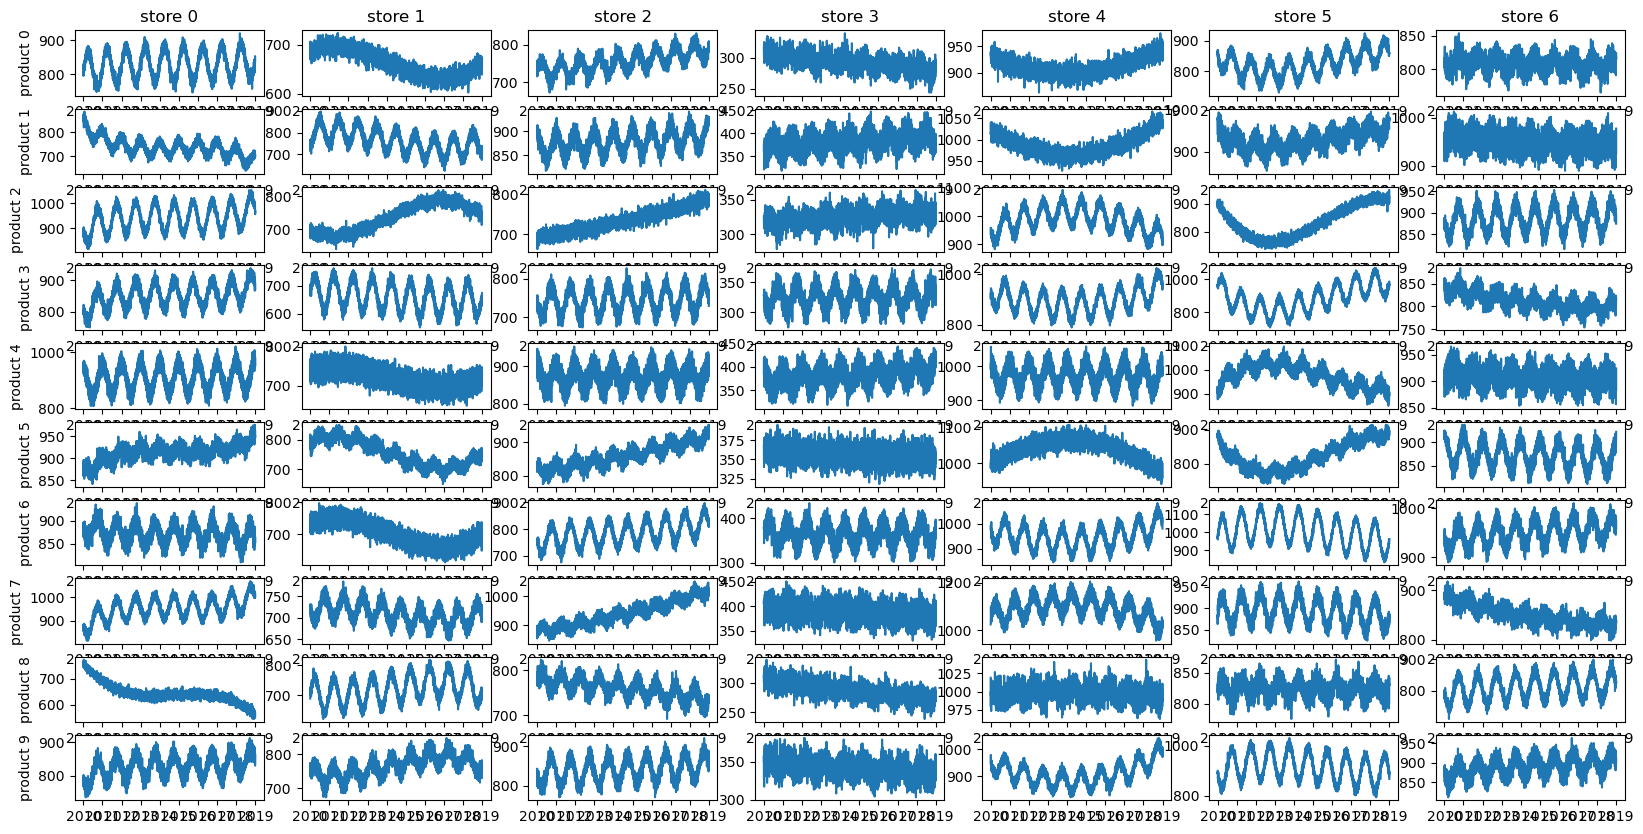

In [8]:
fig, ax = plt.subplots(10,7, figsize=(20, 10))

for s in range(7):
    for p in range(10):
        sns.lineplot(x='Date', y='number_sold', data=df[(df['store']==s) & (df['product']==p)], ax= ax[p, s])
        ax[p, s].set_xlabel('')
        ax[p, s].set_ylabel('')
    ax[0, s].set_title(f'store {s}')
for p in range(10):
    ax[p, 0].set_ylabel(f'product {p}')

As seen from the table above, the mixture of all combinations is quite complex. For example:
- Product 1 and store 1 has a trend and also seasonality 
- Product 0 and store 1 has a trend (which has changed over time) but there seems no clear seasonality visible to the eye
- Product 7 and store 3 has no clear tren and no seasonality 

We see that product 0 and 2 are inversely correlated for store 1. One could say that the products are substitues, 
however this relationship is not visible in other stores so that does not hold. There are also other relationships that 
are clear to the eye across products and store
Overall the variance of all series is relatively constant over time, so there's no need for apply a transformation 
that would make variance constant over time

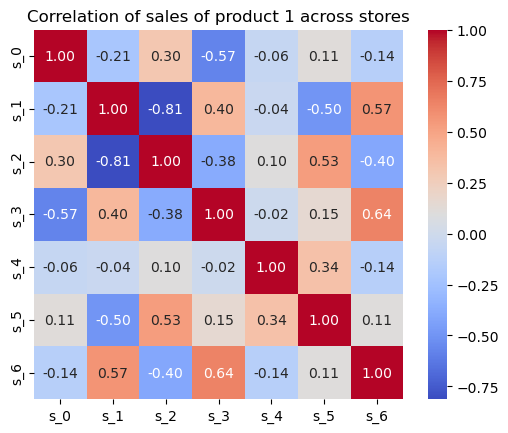

In [9]:
# Look at correlations
p=1
new_df = df[(df['store']==0) & (df['product']==p)].sort_values(by=['Date'])[['Date', 'number_sold']].copy(deep=True)
for s in range(0,7):
    new_df[f's_{s}'] = df[(df['store']==s) & (df['product']==p)].sort_values(by=['Date'])['number_sold'].values

sns.heatmap(new_df[new_df.columns[2:]].corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title(f'Correlation of sales of product {p} across stores')
plt.show()
        

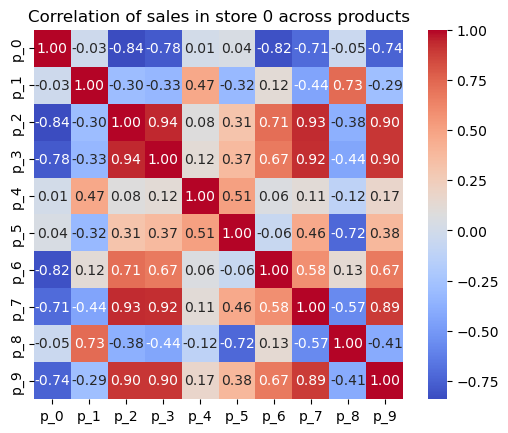

In [10]:
# Look at correlations
s=0
new_df = df[(df['store']==s) & (df['product']==0)].sort_values(by=['Date'])[['Date', 'number_sold']].copy(deep=True)
for p in range(0,10):
    new_df[f'p_{p}'] = df[(df['store']==s) & (df['product']==p)].sort_values(by=['Date'])['number_sold'].values

sns.heatmap(new_df[new_df.columns[2:]].corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title(f'Correlation of sales in store {s} across products')
plt.show()
        

## 2.2 Plot avg sales by day of week

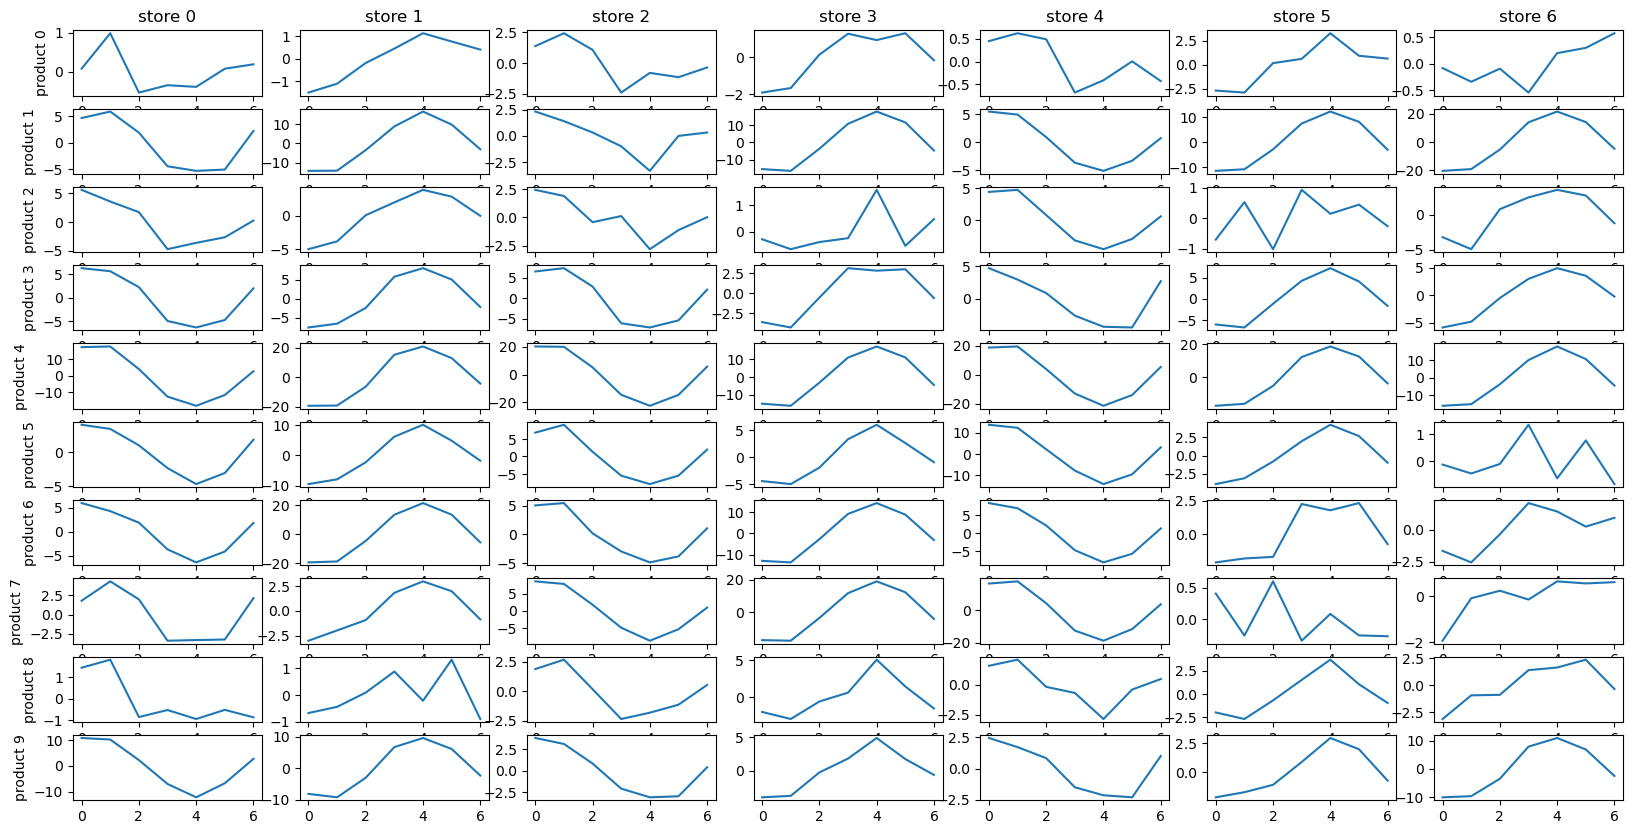

In [11]:
fig, ax = plt.subplots(10,7, figsize=(20, 10))

df_plot_quarter = df.groupby(['store', 'product', 'day_of_week'], as_index=False)['y_diff'].mean()
for s in range(7):
    for p in range(10):
        sns.lineplot(x='day_of_week', y='y_diff', data=df_plot_quarter[(df_plot_quarter['store']==s) & (df_plot_quarter['product']==p)], ax= ax[p, s])
        ax[p, s].set_xlabel('')
        ax[p, s].set_ylabel('')
    ax[0, s].set_title(f'store {s}')
for p in range(10):
    ax[p, 0].set_ylabel(f'product {p}')

#### From the graph there seems to be a relationship between the day of the week and it's impact on sales

## 2.3 Plot y_diff for all combinations

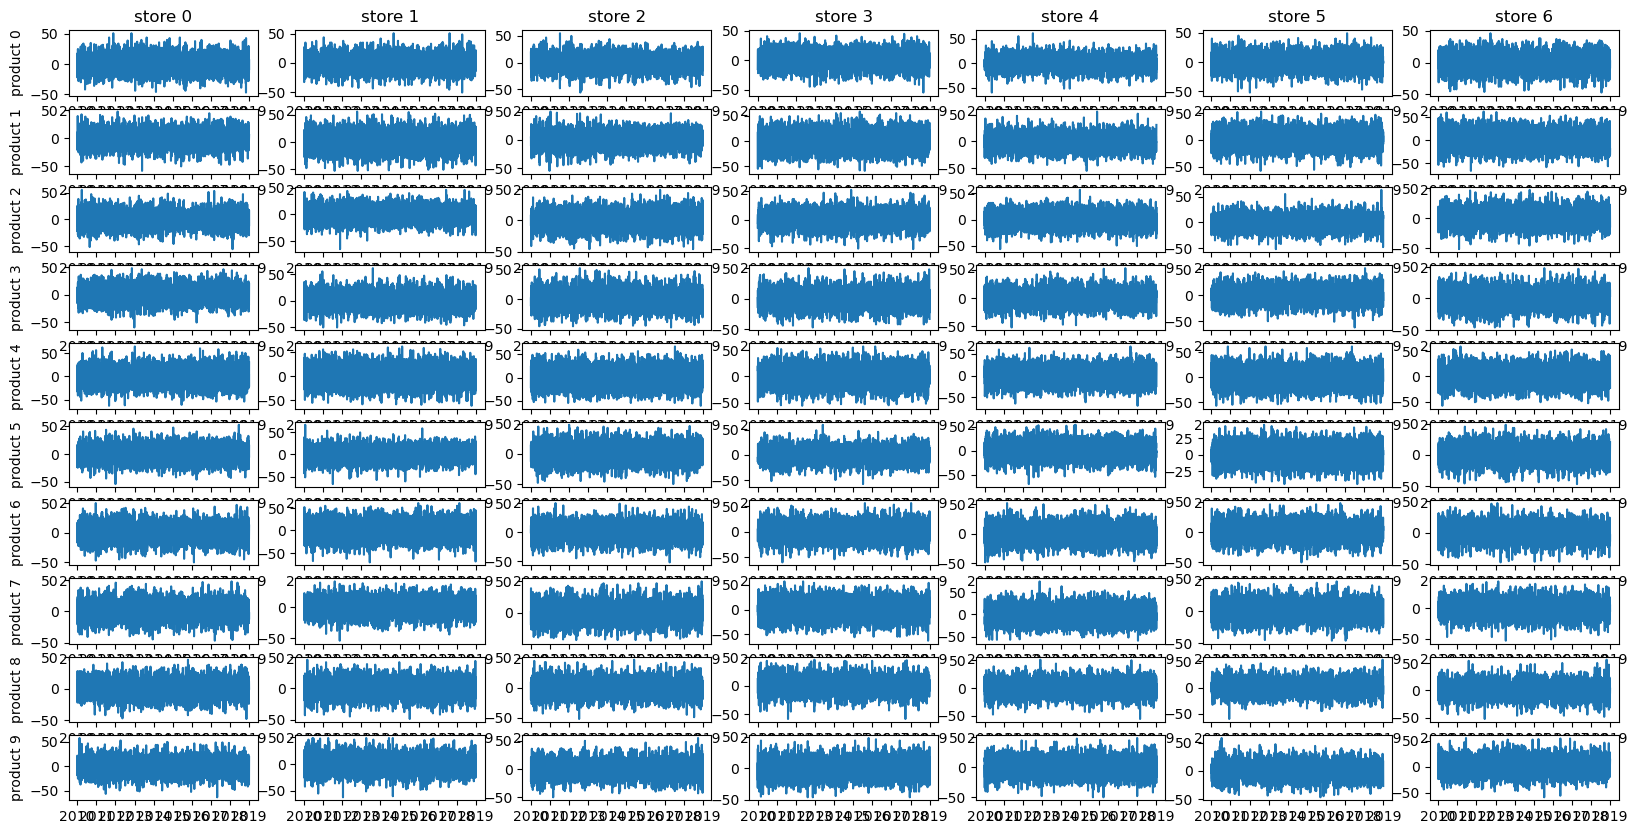

In [12]:
fig, ax = plt.subplots(10,7, figsize=(20, 10))

for s in range(7):
    for p in range(10):
        sns.lineplot(x='Date', y='y_diff', data=df[(df['store']==s) & (df['product']==p)& (~df['y_diff'].isna())], ax= ax[p, s])
        ax[p, s].set_xlabel('')
        ax[p, s].set_ylabel('')
    ax[0, s].set_title(f'store {s}')
for p in range(10):
    ax[p, 0].set_ylabel(f'product {p}')

#### Looking at the plot above, we can see that there's no clear trends anymore in the series. The mean and variance 
#### seems constant over time for all combinations and judging on the plot we can say that the transformed data is stationary. 
#### To be more concise we can use the Augmented Dickey Fuller test for stationarity:

In [13]:
# If the series are not stationary according to the test we take the first difference 
# and test the stationarity of the first difference as well. The reason for doing this is
# so we know which model to use for each series 

stationary_res = []

for s in df['store'].unique():
    for p in df['product'].unique():
        df_temp = df[(df['store']==s) & (df['product']==p)].copy(deep=True)
        adf_test = adfuller(df_temp['number_sold'])
        if adf_test[1]<0.05:
            stationary_1 = 1
            stationary_diff = np.nan
        else:
            stationary_1 = 0
            adf_test_diff = adfuller(df_temp[~df_temp['y_diff'].isna()]['y_diff'])
            if adf_test_diff[1]<0.05:
                stationary_diff = 1
            else:
                stationary_diff = 0
        stationary_res.append([s, p, stationary_1, stationary_diff])


In [14]:
df_stationary = pd.DataFrame(stationary_res, columns=['store', 'product', 'stationary', 'stationary_diff'])
print(f'For {df_stationary.stationary.sum()} combinations we will use the actual values, and for {df_stationary.stationary_diff.sum()} we will integrate differences in our modelling')

For 40 combinations we will use the actual values, and for 30.0 we will integrate differences in our modelling


## 2.4 Plot ACF 

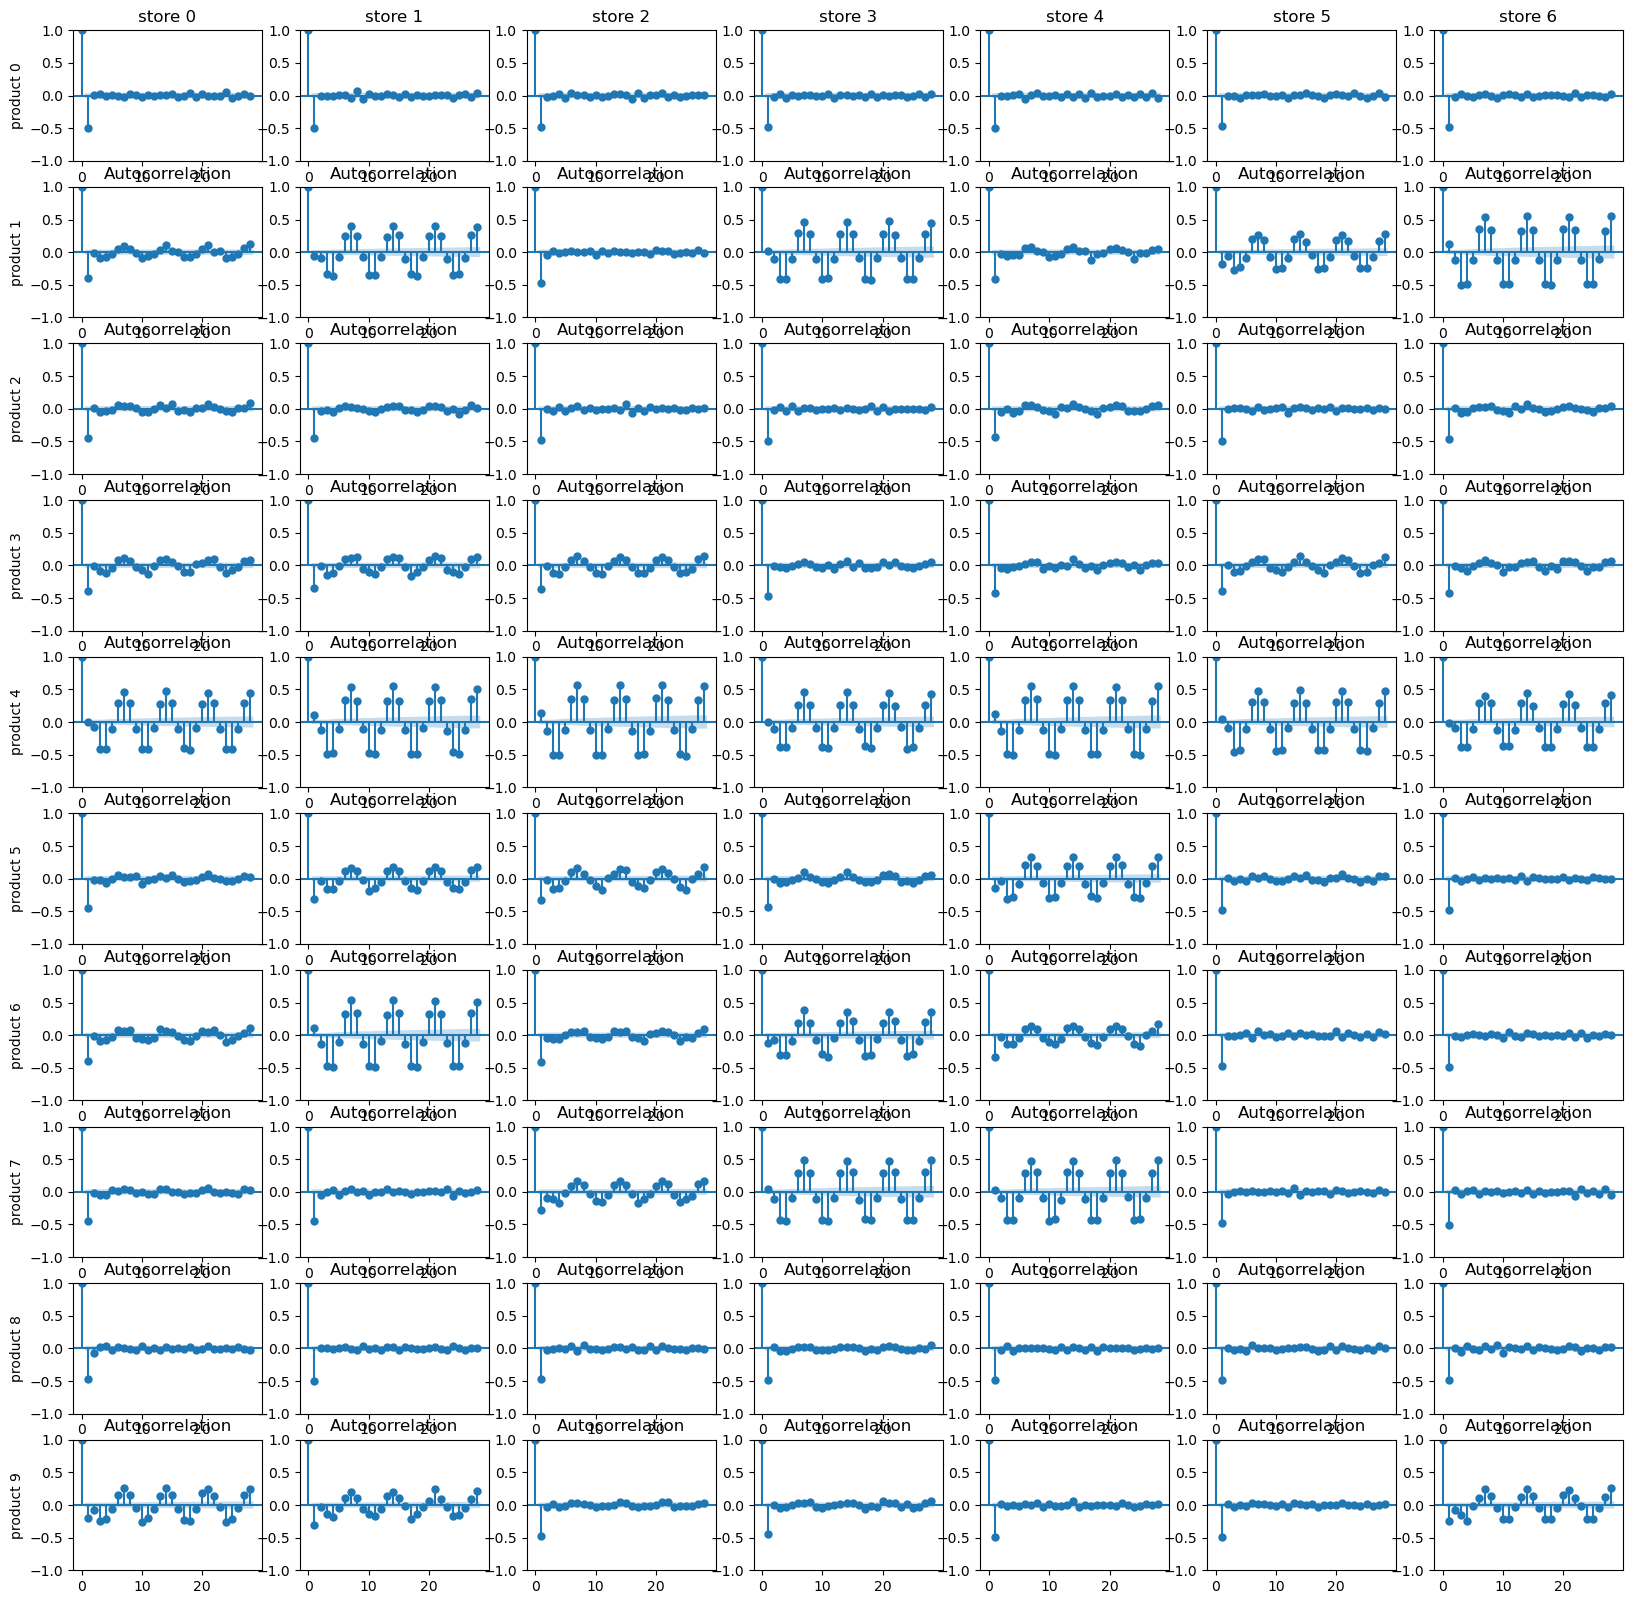

In [15]:
fig, ax = plt.subplots(10,7, figsize=(20, 20))

for s in range(7):
    for p in range(10):
        df_temp = df[(df['store']==s) & (df['product']==p)].copy(deep=True)
        df_temp.set_index('Date', inplace=True)
        plot_acf(df_temp['number_sold'].diff().dropna(), lags=28, ax=ax[p, s])
        ax[p, s].set_xlabel('')
        ax[p, s].set_ylabel('')
    ax[0, s].set_title(f'store {s}')
for p in range(10):
    ax[p, 0].set_ylabel(f'product {p}')


## 2.5 Plot PACF 

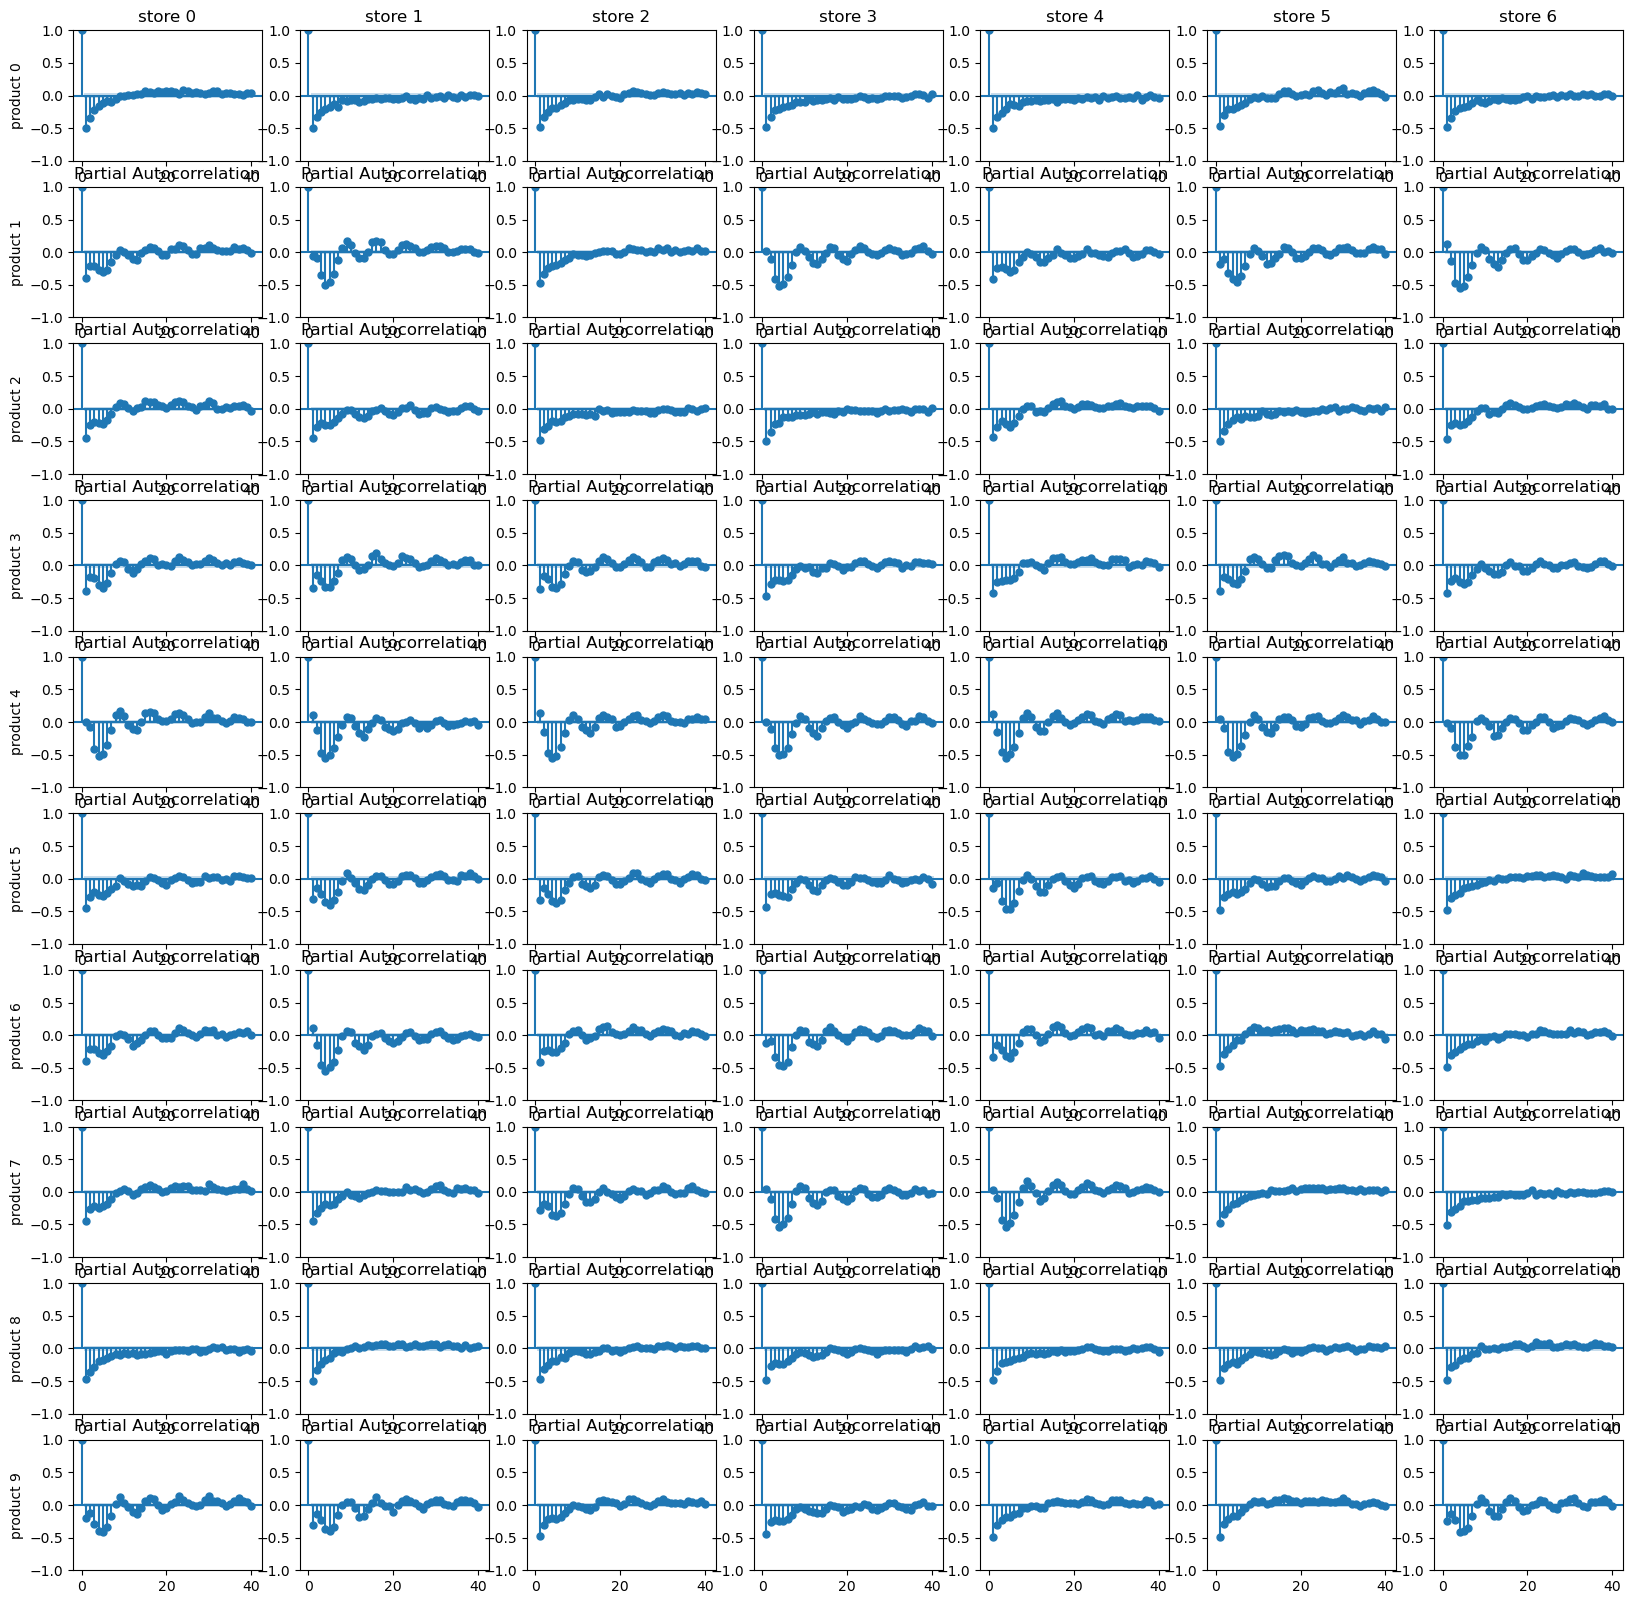

In [16]:
fig, ax = plt.subplots(10,7, figsize=(20, 20))

for s in range(7):
    for p in range(10):
        df_temp = df[(df['store']==s) & (df['product']==p)].copy(deep=True)
        df_temp.set_index('Date', inplace=True)
        plot_pacf(df_temp['number_sold'].diff().dropna(), lags=40, ax=ax[p, s])
        ax[p, s].set_xlabel('')
        ax[p, s].set_ylabel('')
    ax[0, s].set_title(f'store {s}')
for p in range(10):
    ax[p, 0].set_ylabel(f'product {p}')


## 2.6 Check For Seasonality

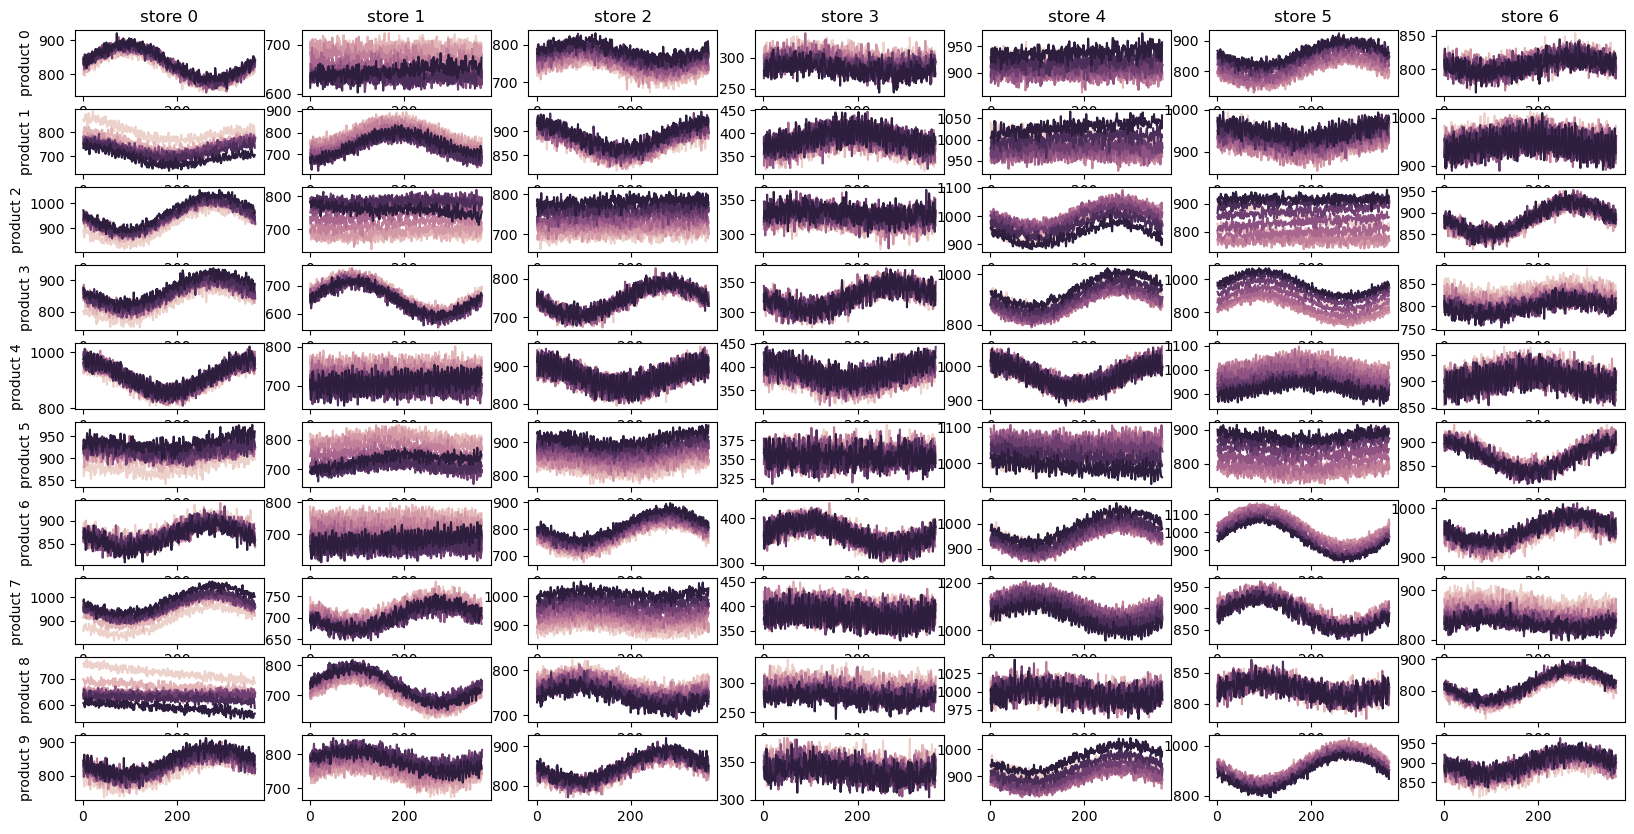

In [17]:
fig, ax = plt.subplots(10,7, figsize=(20, 10))

for s in range(7):
    for p in range(10):
        sns.lineplot(x='day_of_year', y='number_sold', data=df[(df['store']==s) & (df['product']==p)], hue='year', ax= ax[p, s])
        ax[p, s].set_xlabel('')
        ax[p, s].set_ylabel('')
        ax[p, s].legend_.remove()
    ax[0, s].set_title(f'store {s}')
    
for p in range(10):
    ax[p, 0].set_ylabel(f'product {p}')
    

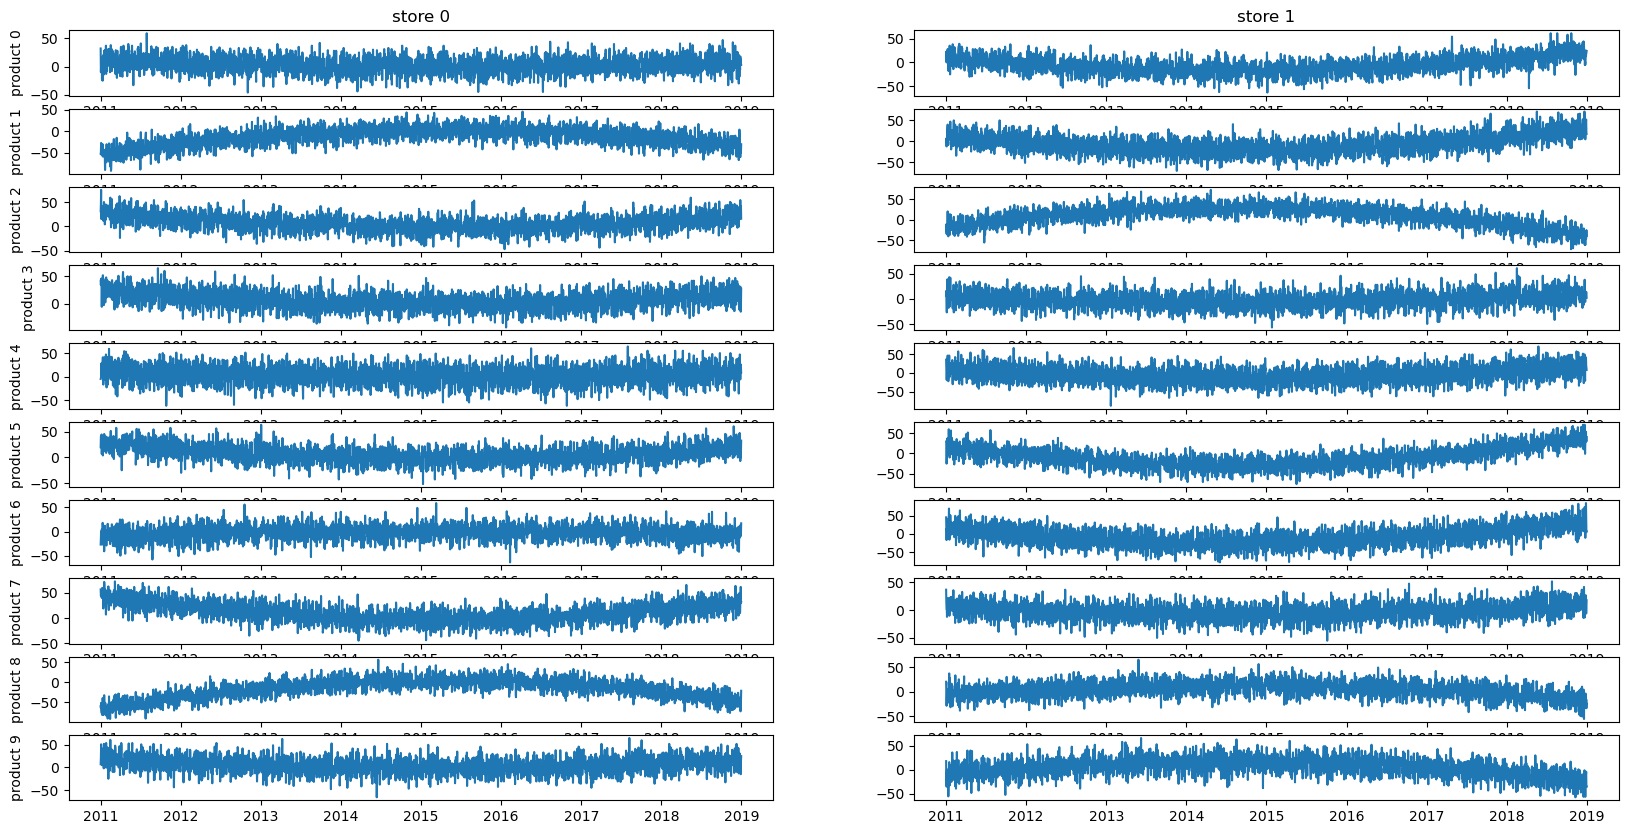

In [18]:
df['yearly_diff'] = df.groupby(['store', 'product'])['number_sold'].diff(365)
fig, ax = plt.subplots(10,2, figsize=(20, 10))

for s in range(2):
    for p in range(10):
        sns.lineplot(x='Date', y='yearly_diff', data=df[(df['store']==s) & (df['product']==p) & (~df['yearly_diff'].isna())], ax= ax[p, s])
        ax[p, s].set_xlabel('')
        ax[p, s].set_ylabel('')

    ax[0, s].set_title(f'store {s}')
    
for p in range(10):
    ax[p, 0].set_ylabel(f'product {p}')

When we plot sales by the day of the year we see that we don't have a seasonality anymore. 
So within the year we don't have a repeated pattern anymore. However in the previous graph we could detect
seasonality quite well, which implies that seasonality is yearly. Also for some combinations there is cyclicatily, 
most of them look like the sine or cosine graph.  When plotting PACF and ACF we could see that for some 
combinations seasonality is weekly.


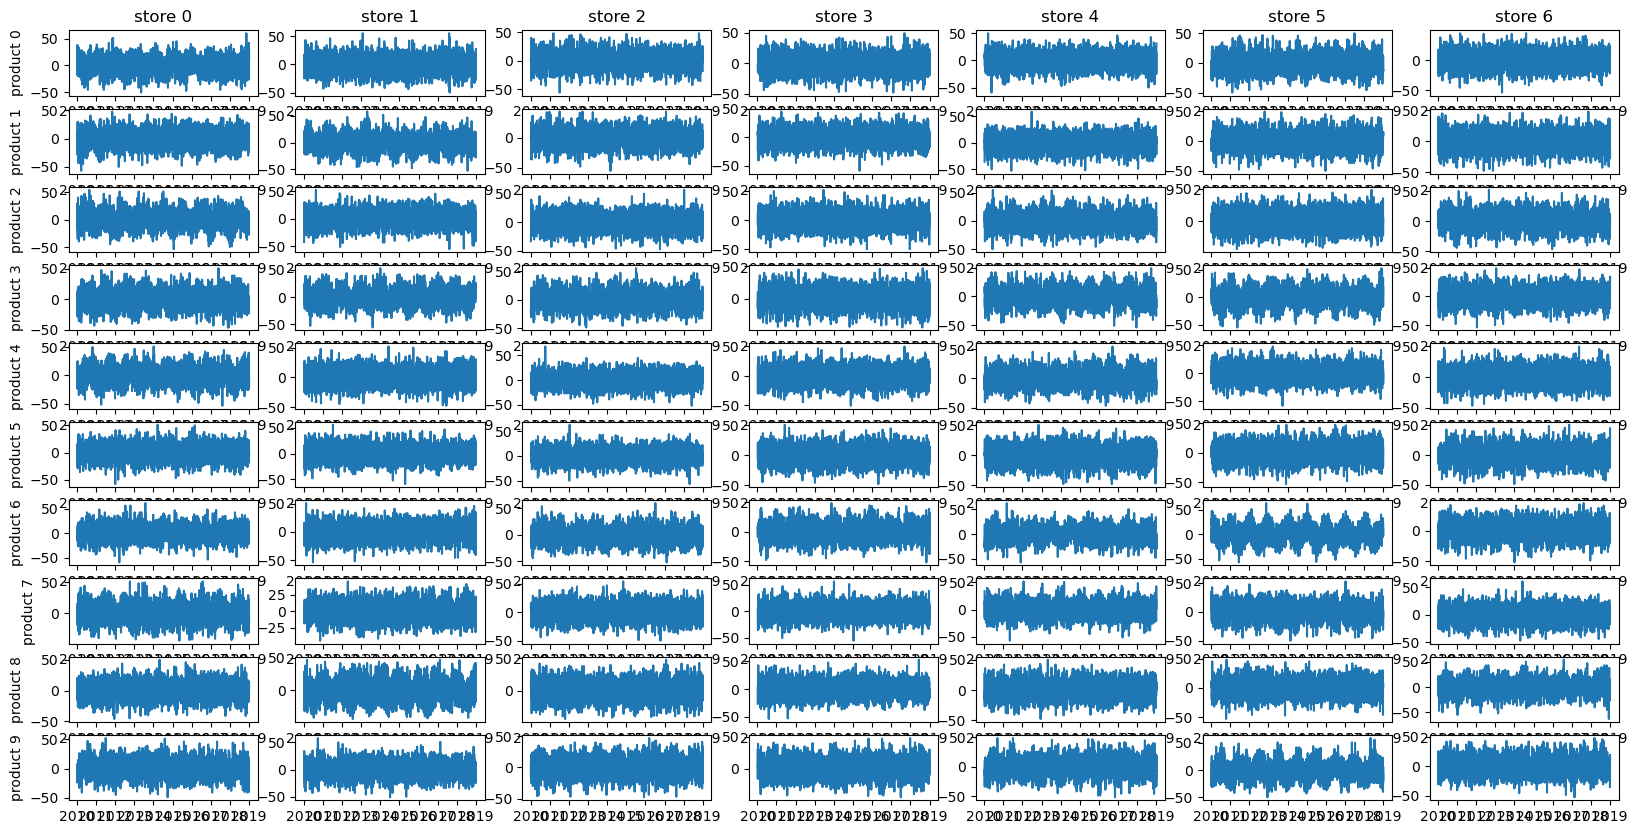

In [19]:
df['7day_diff'] = df.groupby(['store', 'product'])['number_sold'].diff(7)
fig, ax = plt.subplots(10,7, figsize=(20, 10))

for s in range(7):
    for p in range(10):
        sns.lineplot(x='Date', y='7day_diff', data=df[(df['store']==s) & (df['product']==p) & (~df['7day_diff'].isna())], ax= ax[p, s])
        ax[p, s].set_xlabel('')
        ax[p, s].set_ylabel('')

    ax[0, s].set_title(f'store {s}')
    
for p in range(10):
    ax[p, 0].set_ylabel(f'product {p}')

Adding seasonality, using SARIMA makes the model very complex and difficul to train. I have to train 70 of these, 
and for the sake of this exercise, I am using the ARIMA model instead. 

# 3. Fit ARIMA models for all series and generate forecasts

In [44]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
forecasts = []
for s in range(7):
    for p in range(10):
        train_temp = df_train[(df_train['store']==s) & (df_train['product']==p)].copy(deep=True)
        train_temp = train_temp.set_index('Date')
        d = 1 - df_stationary[(df_stationary['store']==s) & (df_stationary['product']==p)]['stationary'].iloc[0]
        model = ARIMA(train_temp['number_sold'], order=(28, d, 6))
        results = model.fit()
        forecast = results.forecast(steps=364)
        forecast_df = forecast.reset_index()
        forecast_df['store'] = s
        forecast_df['product']=p
        forecasts.append(forecast_df)

        # .rename(columns={'index':'Date'})

# Print summary
print(results.summary())


/opt/anaconda3/envs/basic/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/basic/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/basic/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/basic/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/basic/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No f

                               SARIMAX Results                                
Dep. Variable:            number_sold   No. Observations:                 3287
Model:                ARIMA(28, 1, 6)   Log Likelihood              -12512.661
Date:                Tue, 10 Jun 2025   AIC                          25095.323
Time:                        18:18:51   BIC                          25308.732
Sample:                    01-01-2010   HQIC                         25171.731
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5424      0.157     -3.462      0.001      -0.849      -0.235
ar.L2          0.0310      0.111      0.279      0.780      -0.187       0.249
ar.L3          0.0881      0.106      0.830      0.4

## 3.1 Plot predictions vs actuals

In [103]:
df_preds = pd.concat(forecasts).rename(columns={'index':"Date"})
df_comb = df_preds.merge(df_test[['Date', 'store', 'product', 'number_sold']], on = ['Date', 'store', 'product'])

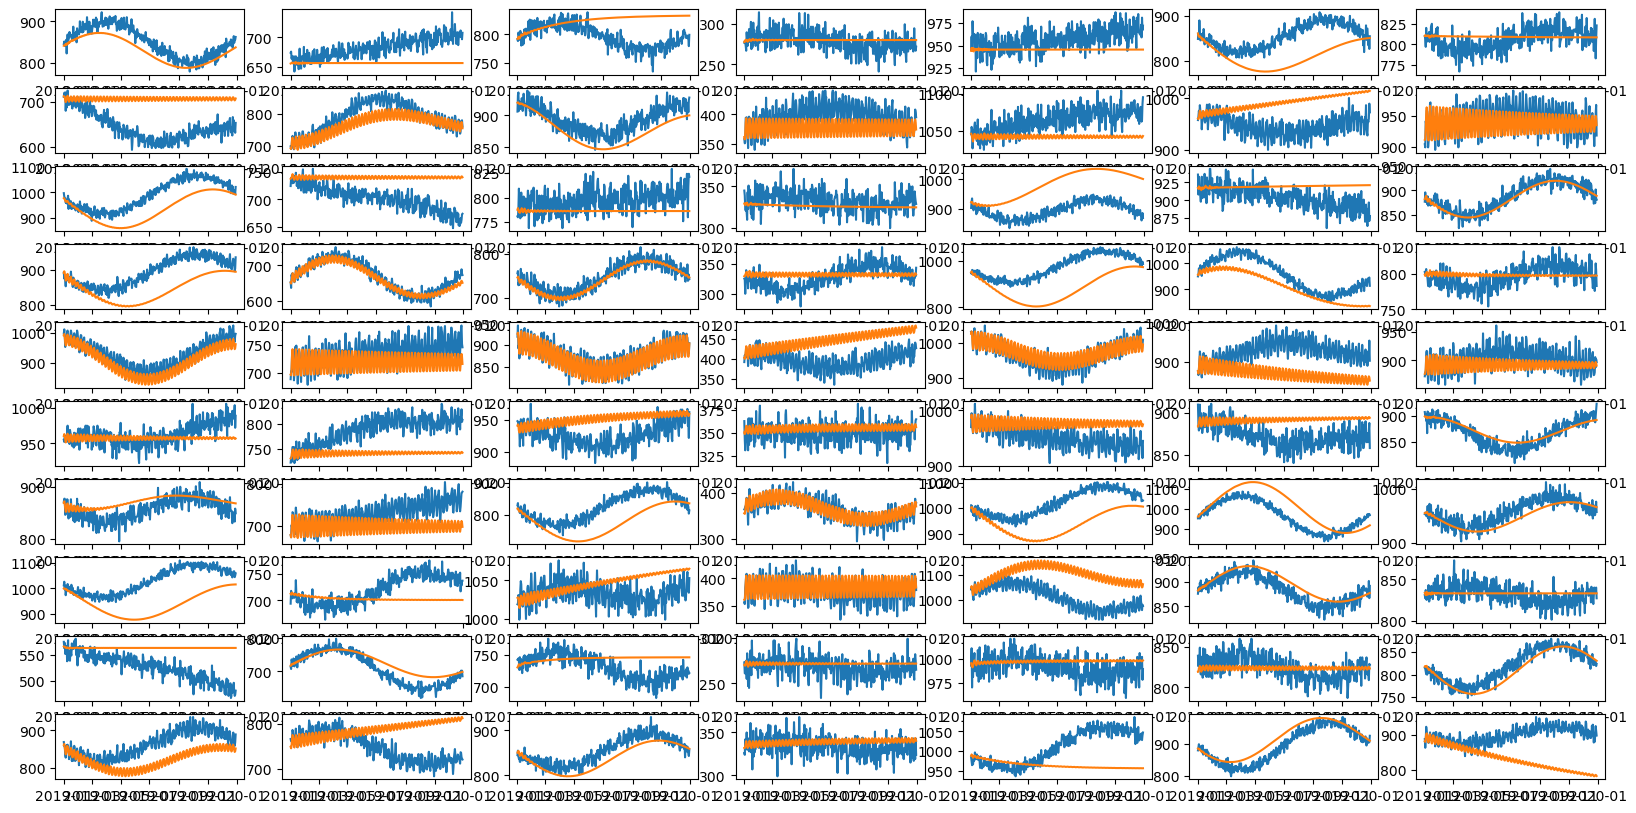

In [104]:
fig, ax = plt.subplots(10,7, figsize=(20, 10))
for s in range(7):
    for p in range(10):
        sns.lineplot(
            x='Date', 
            y = 'number_sold', 
            data = df_comb[(df_comb['product']==p) & (df_comb['store']==s)], 
            label= 'actual', 
            ax=ax[p,s])
        sns.lineplot(x='Date', y = 'predicted_mean', data = df_comb[(df_comb['product']==p) & (df_comb['store']==s)], label = 'forecast', ax=ax[p,s])
        ax[p,s].legend_.remove()
        ax[p,s].set_ylabel('')
        ax[p,s].set_xlabel('')

Removed legends because the plot is too crowded. The blue line is the actual values of the test set, and the orange line are the forecasts

## 3.2 Decompose plots

### 3.2.1 Series with integrated differencing

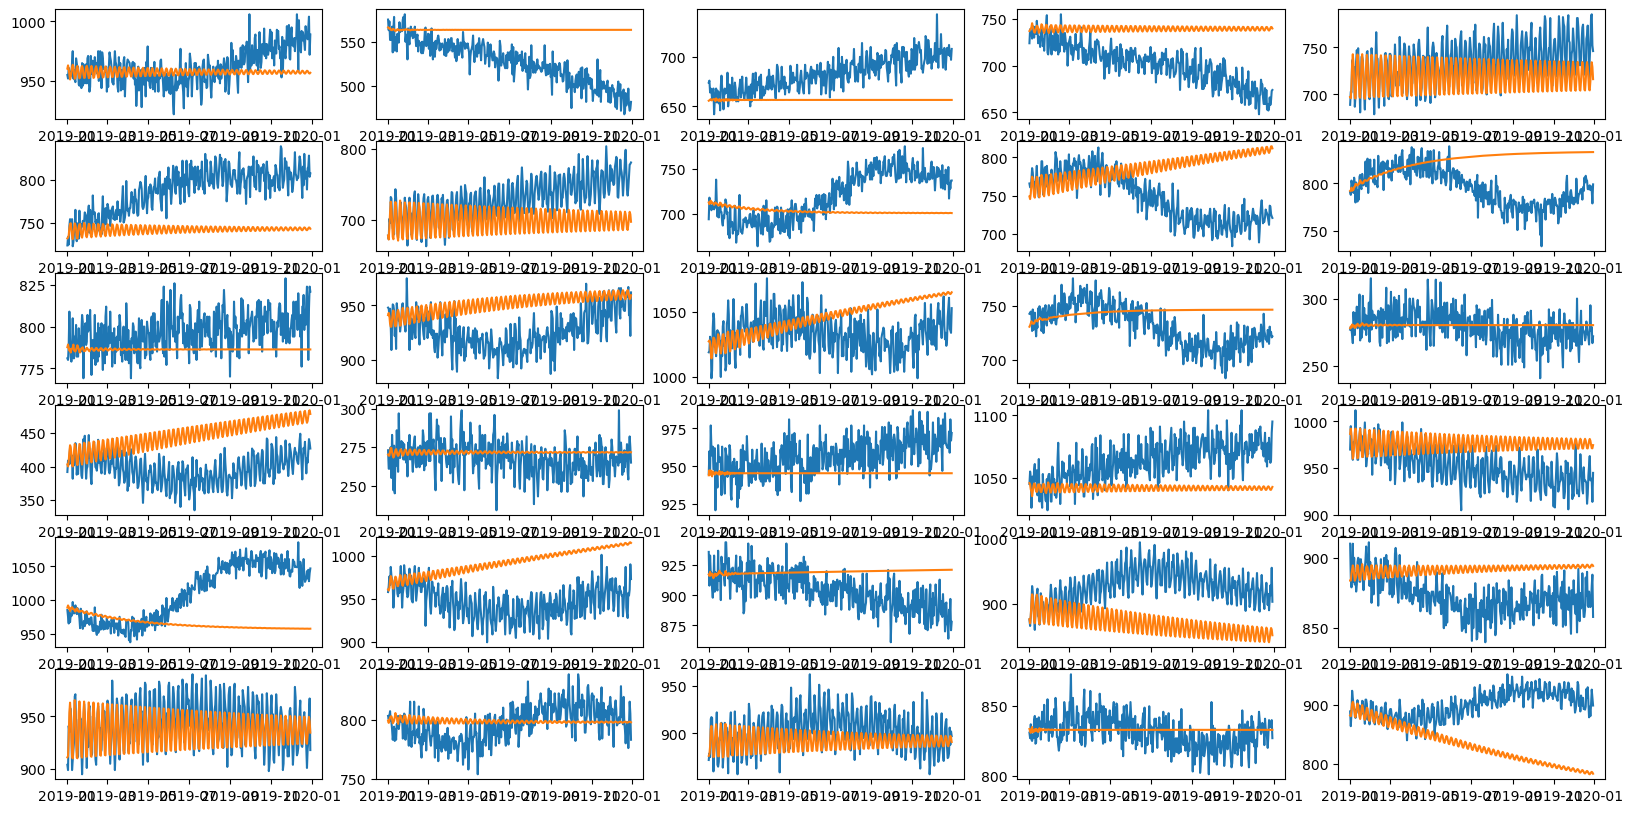

In [83]:
fig, ax = plt.subplots(6, 5, figsize=(20, 10))
i = 0
diff_pairs = df_stationary[df_stationary['stationary']==0][['store', 'product']].values
for s, p in diff_pairs:
    row, col = int(i/5), i%5
    i+=1
    sns.lineplot(
        x='Date', 
        y = 'number_sold', 
        data = df_comb[(df_comb['product']==p) & (df_comb['store']==s)], 
        label= 'actual', 
        ax=ax[row, col])
    sns.lineplot(x='Date', y = 'predicted_mean', data = df_comb[(df_comb['product']==p) & (df_comb['store']==s)], label = 'forecast', ax=ax[row, col])
    ax[row, col].legend_.remove()
    ax[row, col].set_ylabel('')
    ax[row, col].set_xlabel('')

### 3.2.2 Series without integrated differencing

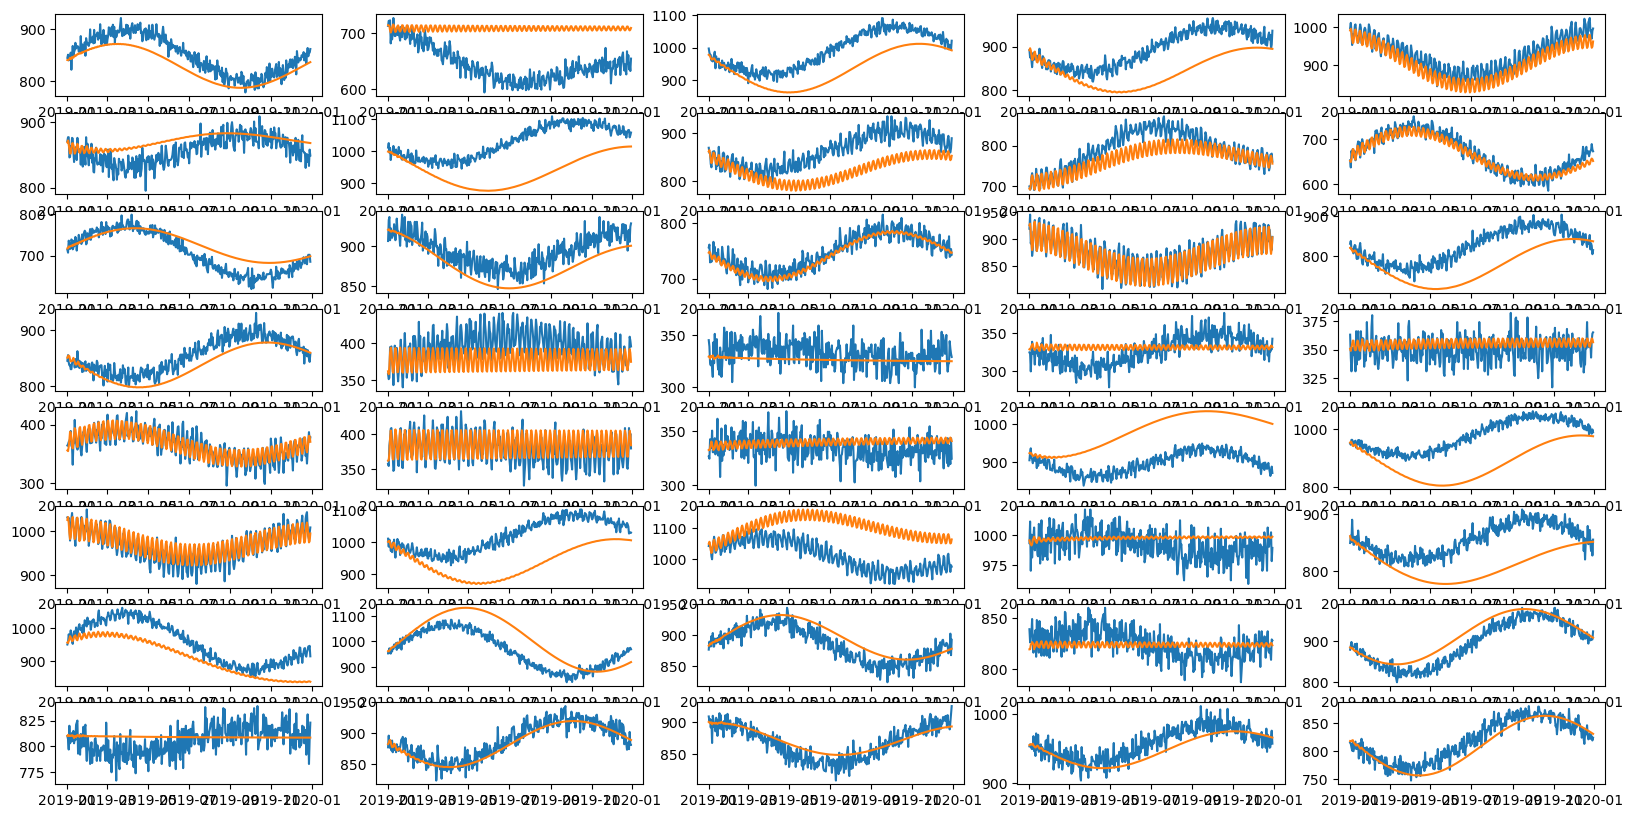

In [84]:
fig, ax = plt.subplots(8, 5, figsize=(20, 10))
pairs = df_stationary[df_stationary['stationary']!=0][['store', 'product']].values
i = 0
for s, p in pairs:
    row, col = int(i/5), i%5
    i+=1
    sns.lineplot(
        x='Date', 
        y = 'number_sold', 
        data = df_comb[(df_comb['product']==p) & (df_comb['store']==s)], 
        label= 'actual', 
        ax=ax[row, col])
    sns.lineplot(x='Date', y = 'predicted_mean', data = df_comb[(df_comb['product']==p) & (df_comb['store']==s)], label = 'forecast', ax=ax[row, col])
    ax[row, col].legend_.remove()
    ax[row, col].set_ylabel('')
    ax[row, col].set_xlabel('')

FROM THE PICTURES shown above, all the store - product pairs trained with ARIMA(p, 1, q) fail to capture any trends or seasonality in the test set. For that reason we will train all models with d=0 ARIMA(p, 0, q)

In [82]:
mean_absolute_percentage_error(df_comb['number_sold'], df_comb['predicted_mean'])

0.038005713231686056